# Make the Decile

In [1]:
#merge the two gene lists
import pandas as pd
import numpy as np
from gprofiler import GProfiler

graph = pd.read_csv('Results/node2vec_lr_clean.csv')
graph=graph[["Gene","Ensembl_ID"]]
trans= pd.read_csv('xgb_clean.csv')

print(f"trans size = {trans.shape}")

merge_trans = pd.merge(graph,trans, on='Ensembl_ID', how='inner')

print(f"merge size = {merge_trans.shape}")

trans size = (18933, 6)
merge size = (18094, 7)


In [2]:
merge_trans

,Gene_x,Ensembl_ID,Gene_y,Probability_Class_0,Probability_Class_1,Chromosome,SFARI_Gene_Score
0,AUTS2,ENSG00000158321,AUTS2,0.314191,0.685809,7,1.0
1,ADNP,ENSG00000101126,ADNP,0.162942,0.837058,20,1.0
2,MBD5,ENSG00000204406,MBD5,0.018279,0.981721,2,1.0
3,CHD8,ENSG00000100888,CHD8,0.000046,0.999954,14,1.0
4,PTCHD1,ENSG00000165186,PTCHD1,0.999666,0.000334,X,1.0
...,...,...,...,...,...,...,...
18089,INHA,ENSG00000123999,INHA,0.999937,0.000063,2,NaN
18090,MS4A12,ENSG00000071203,MS4A12,0.999639,0.000361,11,NaN
18091,SCGB1A1,ENSG00000149021,SCGB1A1,0.999989,0.000011,11,NaN
18092,ABCA4,ENSG00000198691,ABCA4,0.998107,0.001893,1,NaN


In [4]:

graph = pd.read_csv('Results/node2vec_lr_clean.csv')

data = graph.copy()

data["Decile_rank"] = pd.qcut(data["Probability_Class_1"], 10, labels=False)
data["Decile_rank"] = data["Decile_rank"].astype('category')
data["Decile_rank"] = data["Decile_rank"].cat.rename_categories([f'D{i}' for i in range(10,0,-1)])

deciles = {}
for i in range(1, 11):
    deciles[f'd_{i}'] = data[data["Decile_rank"] == f'D{i}'].copy()


# Gene enrich

In [5]:
def gprofiler(genes):
    gp = GProfiler(return_dataframe=True)
    gp_results = gp.profile(organism='hsapiens', query=genes,sources=['HP'],user_threshold=1)
    return gp_results

In [6]:
decile_list = deciles['d_1']["Ensembl_ID"].to_list()
test=gprofiler(decile_list)
test.head(10)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,HP,HP:0000729,Autistic behavior,2.288490e-71,True,Persistent deficits in social interaction and ...,582,486,204,4958,0.419753,0.350515,query_1,[HP:0000708]
1,HP,HP:0001249,Intellectual disability,1.003870e-57,True,"Intellectual disability, previously referred t...",2023,486,368,4958,0.757202,0.181908,query_1,"[HP:0011446, HP:0012759]"
2,HP,HP:5200241,Recurrent maladaptive behavior,5.723630e-52,True,A repeating behavior that is either immediatel...,1081,486,254,4958,0.522634,0.234968,query_1,[HP:0000708]
3,HP,HP:0000752,Hyperactivity,2.252328e-51,True,Hyperactivity is a condition characterized by ...,546,486,174,4958,0.358025,0.318681,query_1,[HP:0000734]
4,HP,HP:0000734,Disinhibition,4.013706e-51,True,"Reduced ability to control, or a failure to re...",620,486,186,4958,0.382716,0.300000,query_1,[HP:5200241]
5,HP,HP:0000750,Delayed speech and language development,5.752961e-48,True,A degree of language development that is signi...,1073,486,247,4958,0.508230,0.230196,query_1,"[HP:0002167, HP:0002463, HP:0012758]"
6,HP,HP:0002463,Language impairment,9.956353e-48,True,Language impairment is a deficit in comprehens...,1130,486,254,4958,0.522634,0.224779,query_1,[HP:0034434]
7,HP,HP:0001252,Hypotonia,6.545621e-46,True,Hypotonia is an abnormally low muscle tone (th...,1808,486,329,4958,0.676955,0.181969,query_1,[HP:0003808]
8,HP,HP:0034434,Abnormal communication,4.430689e-45,True,"Presence of any form of communication (e.g., v...",1716,486,318,4958,0.654321,0.185315,query_1,[HP:0011446]
9,HP,HP:0001263,Global developmental delay,1.024658e-43,True,A delay in the achievement of motor or mental ...,1901,486,335,4958,0.689300,0.176223,query_1,[HP:0012758]


# All results

In [7]:
def get_decile_results(deciles,hp_term="HP:0000717"):
    dataframes= []
    for i,key in enumerate(deciles):
        decile_list = deciles[key]["Ensembl_ID"].to_list()
        print(f'Processing {key,hp_term}...')
        decile_results = gprofiler(decile_list)
        decile_results.insert(0, "Decile", i+1)
        decile_results=decile_results[decile_results['native']==hp_term]
        dataframes.append(decile_results)

    data = pd.concat(dataframes)
    data= data.sort_values(by='Decile', ascending=False).reset_index(drop=True)
    data['Intersection_to_Term_Ratio'] = data['intersection_size'] / data['term_size']
    data=data.sort_values(by='Decile', ascending=True).reset_index(drop=True)
    return data


In [8]:
autistic_behaviour=get_decile_results(deciles,hp_term="HP:0000729"),"Autistic behaviour"
delayed_speech=get_decile_results(deciles,hp_term="HP:0000750"),"Delayed speech and language development"
repetitive_behaviour=get_decile_results(deciles,hp_term="HP:0031432"),"Restricted or repetitive behaviors or interests"


adhd=get_decile_results(deciles,hp_term="HP:0007018"),"ADHD"
intellectual_disability=get_decile_results(deciles,hp_term="HP:0001249"),"Intellectual disability"
scz=get_decile_results(deciles,hp_term="HP:0100753"),"Schizophrenia"

als=get_decile_results(deciles,hp_term="HP:0007354"),"Amyotrophic lateral sclerosis"
parkinsons = get_decile_results(deciles, hp_term="HP:0001300"), "Parkinsonism"
dementia=get_decile_results(deciles,hp_term="HP:0000726"),"Dementia"

Processing ('d_1', 'HP:0000729')...
Processing ('d_2', 'HP:0000729')...
Processing ('d_3', 'HP:0000729')...
Processing ('d_4', 'HP:0000729')...
Processing ('d_5', 'HP:0000729')...
Processing ('d_6', 'HP:0000729')...
Processing ('d_7', 'HP:0000729')...
Processing ('d_8', 'HP:0000729')...
Processing ('d_9', 'HP:0000729')...
Processing ('d_10', 'HP:0000729')...
Processing ('d_1', 'HP:0000750')...
Processing ('d_2', 'HP:0000750')...
Processing ('d_3', 'HP:0000750')...
Processing ('d_4', 'HP:0000750')...
Processing ('d_5', 'HP:0000750')...
Processing ('d_6', 'HP:0000750')...
Processing ('d_7', 'HP:0000750')...
Processing ('d_8', 'HP:0000750')...
Processing ('d_9', 'HP:0000750')...
Processing ('d_10', 'HP:0000750')...
Processing ('d_1', 'HP:0031432')...
Processing ('d_2', 'HP:0031432')...
Processing ('d_3', 'HP:0031432')...
Processing ('d_4', 'HP:0031432')...
Processing ('d_5', 'HP:0031432')...
Processing ('d_6', 'HP:0031432')...
Processing ('d_7', 'HP:0031432')...
Processing ('d_8', 'HP:003

# Mutations results


In [9]:
import requests


def get_token_form_response(response):
    if response.status_code == 200:
        token = response.json()['organism']
    else:
        try:
            error_message = 'Error: {}'.format(response.json()['message'])
        except:
            error_message = 'Error, status code {}'.format(response.status_code)
        raise AssertionError(error_message)
    #print("Token:", token)
    return token

def main_custom(deciles, gmt_file,mutation_name):


    dataframes= []
    for i,key in enumerate(deciles):
        decile_list = deciles[key]["Ensembl_ID"].to_list()
        print(f'Processing {key,mutation_name}...')

        gp = GProfiler(
            user_agent='gprofiler_custom_gmt', #optional user agent
            return_dataframe=True, #return pandas dataframe or plain python structures    
        )

        with open(gmt_file) as f:
            response = requests.post('https://biit.cs.ut.ee/gprofiler/api/gost/custom/',
                            json={'gmt':f.read(),
                                'name': gmt_file})
        token = get_token_form_response(response)

        decile_results = gp.profile(query=decile_list, organism=token,user_threshold=1)
        decile_results.insert(0, "Decile", i+1)
        decile_results=decile_results[decile_results['native']==mutation_name]
        dataframes.append(decile_results)


    data = pd.concat(dataframes)
    data= data.sort_values(by='Decile', ascending=False).reset_index(drop=True)
    data['Intersection_to_Term_Ratio'] = data['intersection_size'] / data['term_size']
    data=data.sort_values(by='Decile', ascending=True).reset_index(drop=True)

    return data




In [10]:

lof_d = main_custom(deciles, r'mut\merged_mutation_denovo.gmt','Lof'),"Denovo Lof"
synonymous_SNV_d = main_custom(deciles, r'mut\merged_mutation_denovo.gmt','synonymous SNV'),"Synonymous SNV denovo"
nonsynonymous_SNV_d = main_custom(deciles, r'mut\merged_mutation_denovo.gmt','nonsynonymous SNV'),"Nonsynonymous SNV denovo"

lof_in = main_custom(deciles, r'mut\merged_mutation_inher.gmt','Lof'),"Inherited Lof"
synonymous_SNV_in = main_custom(deciles, r'mut\merged_mutation_inher.gmt','synonymous SNV'),"Synonymous SNV inherited"
nonsynonymous_SNV_in = main_custom(deciles, r'mut\merged_mutation_inher.gmt','nonsynonymous SNV'),"Nonsynonymous SNV inherited"

Processing ('d_1', 'Lof')...
Processing ('d_2', 'Lof')...
Processing ('d_3', 'Lof')...
Processing ('d_4', 'Lof')...
Processing ('d_5', 'Lof')...
Processing ('d_6', 'Lof')...
Processing ('d_7', 'Lof')...
Processing ('d_8', 'Lof')...
Processing ('d_9', 'Lof')...
Processing ('d_10', 'Lof')...
Processing ('d_1', 'synonymous SNV')...
Processing ('d_2', 'synonymous SNV')...
Processing ('d_3', 'synonymous SNV')...
Processing ('d_4', 'synonymous SNV')...
Processing ('d_5', 'synonymous SNV')...
Processing ('d_6', 'synonymous SNV')...
Processing ('d_7', 'synonymous SNV')...
Processing ('d_8', 'synonymous SNV')...
Processing ('d_9', 'synonymous SNV')...
Processing ('d_10', 'synonymous SNV')...
Processing ('d_1', 'nonsynonymous SNV')...
Processing ('d_2', 'nonsynonymous SNV')...
Processing ('d_3', 'nonsynonymous SNV')...
Processing ('d_4', 'nonsynonymous SNV')...
Processing ('d_5', 'nonsynonymous SNV')...
Processing ('d_6', 'nonsynonymous SNV')...
Processing ('d_7', 'nonsynonymous SNV')...
Process

In [11]:
proband_denovo_rec_lof=main_custom(deciles, r'mut\krish_duda.gmt','prb_rec_LGD'),"Denovo recurrent LOF"
proband_denovo=main_custom(deciles, r'mut\krish_duda.gmt','prb_LGD'),"Denovo LOF"
siblings_denovo=main_custom(deciles, r'mut\krish_duda.gmt','sib_LGD'),"Denovo siblings LOF"

Processing ('d_1', 'prb_rec_LGD')...
Processing ('d_2', 'prb_rec_LGD')...
Processing ('d_3', 'prb_rec_LGD')...
Processing ('d_4', 'prb_rec_LGD')...
Processing ('d_5', 'prb_rec_LGD')...
Processing ('d_6', 'prb_rec_LGD')...
Processing ('d_7', 'prb_rec_LGD')...
Processing ('d_8', 'prb_rec_LGD')...
Processing ('d_9', 'prb_rec_LGD')...
Processing ('d_10', 'prb_rec_LGD')...
Processing ('d_1', 'prb_LGD')...
Processing ('d_2', 'prb_LGD')...
Processing ('d_3', 'prb_LGD')...
Processing ('d_4', 'prb_LGD')...
Processing ('d_5', 'prb_LGD')...
Processing ('d_6', 'prb_LGD')...
Processing ('d_7', 'prb_LGD')...
Processing ('d_8', 'prb_LGD')...
Processing ('d_9', 'prb_LGD')...
Processing ('d_10', 'prb_LGD')...
Processing ('d_1', 'sib_LGD')...
Processing ('d_2', 'sib_LGD')...
Processing ('d_3', 'sib_LGD')...
Processing ('d_4', 'sib_LGD')...
Processing ('d_5', 'sib_LGD')...
Processing ('d_6', 'sib_LGD')...
Processing ('d_7', 'sib_LGD')...
Processing ('d_8', 'sib_LGD')...
Processing ('d_9', 'sib_LGD')...
P

In [12]:
mssng_lof = main_custom(deciles, r'mut\mssng.gmt','MSSNG_LOF'),"MSSNG_LOF"

mssng_novel=main_custom(deciles, r'mut\mssng.gmt','MSSNG_NOVEL'),"MSSNG_NOVEL"
mssng_sig=main_custom(deciles, r'mut\mssng.gmt','MSSNG_SIG'),"MSSNG_SIG"


Processing ('d_1', 'MSSNG_LOF')...
Processing ('d_2', 'MSSNG_LOF')...
Processing ('d_3', 'MSSNG_LOF')...
Processing ('d_4', 'MSSNG_LOF')...
Processing ('d_5', 'MSSNG_LOF')...
Processing ('d_6', 'MSSNG_LOF')...
Processing ('d_7', 'MSSNG_LOF')...
Processing ('d_8', 'MSSNG_LOF')...
Processing ('d_9', 'MSSNG_LOF')...
Processing ('d_10', 'MSSNG_LOF')...
Processing ('d_1', 'MSSNG_NOVEL')...
Processing ('d_2', 'MSSNG_NOVEL')...
Processing ('d_3', 'MSSNG_NOVEL')...
Processing ('d_4', 'MSSNG_NOVEL')...
Processing ('d_5', 'MSSNG_NOVEL')...
Processing ('d_6', 'MSSNG_NOVEL')...
Processing ('d_7', 'MSSNG_NOVEL')...
Processing ('d_8', 'MSSNG_NOVEL')...
Processing ('d_9', 'MSSNG_NOVEL')...
Processing ('d_10', 'MSSNG_NOVEL')...
Processing ('d_1', 'MSSNG_SIG')...
Processing ('d_2', 'MSSNG_SIG')...
Processing ('d_3', 'MSSNG_SIG')...
Processing ('d_4', 'MSSNG_SIG')...
Processing ('d_5', 'MSSNG_SIG')...
Processing ('d_6', 'MSSNG_SIG')...
Processing ('d_7', 'MSSNG_SIG')...
Processing ('d_8', 'MSSNG_SIG')..

In [13]:
category_1=main_custom(deciles, r'mut\sfari.gmt','SFARI_cat_1'),"SFARI_cat_1"
category_2=main_custom(deciles, r'mut\sfari.gmt','SFARI_cat_2'),"SFARI_cat_2"
category_3=main_custom(deciles, r'mut\sfari.gmt','SFARI_cat_3'),"SFARI_cat_3"


Processing ('d_1', 'SFARI_cat_1')...
Processing ('d_2', 'SFARI_cat_1')...
Processing ('d_3', 'SFARI_cat_1')...
Processing ('d_4', 'SFARI_cat_1')...
Processing ('d_5', 'SFARI_cat_1')...
Processing ('d_6', 'SFARI_cat_1')...
Processing ('d_7', 'SFARI_cat_1')...
Processing ('d_8', 'SFARI_cat_1')...
Processing ('d_9', 'SFARI_cat_1')...
Processing ('d_10', 'SFARI_cat_1')...
Processing ('d_1', 'SFARI_cat_2')...
Processing ('d_2', 'SFARI_cat_2')...
Processing ('d_3', 'SFARI_cat_2')...
Processing ('d_4', 'SFARI_cat_2')...
Processing ('d_5', 'SFARI_cat_2')...
Processing ('d_6', 'SFARI_cat_2')...
Processing ('d_7', 'SFARI_cat_2')...
Processing ('d_8', 'SFARI_cat_2')...
Processing ('d_9', 'SFARI_cat_2')...
Processing ('d_10', 'SFARI_cat_2')...
Processing ('d_1', 'SFARI_cat_3')...
Processing ('d_2', 'SFARI_cat_3')...
Processing ('d_3', 'SFARI_cat_3')...
Processing ('d_4', 'SFARI_cat_3')...
Processing ('d_5', 'SFARI_cat_3')...
Processing ('d_6', 'SFARI_cat_3')...
Processing ('d_7', 'SFARI_cat_3')...

In [14]:
sfari_full=main_custom(deciles, r'mut\sfari.gmt','SFARI_full'),"SFARI_full"

Processing ('d_1', 'SFARI_full')...
Processing ('d_2', 'SFARI_full')...
Processing ('d_3', 'SFARI_full')...
Processing ('d_4', 'SFARI_full')...
Processing ('d_5', 'SFARI_full')...
Processing ('d_6', 'SFARI_full')...
Processing ('d_7', 'SFARI_full')...
Processing ('d_8', 'SFARI_full')...
Processing ('d_9', 'SFARI_full')...
Processing ('d_10', 'SFARI_full')...


# Graphs


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def pad_dataframe(df):

    decile_dict = {}
    for i in range(1, 11):
        if i not in df['Decile'].unique():
            decile_dict[i] = {'Decile': i,
                              'Intersection_to_Term_Ratio': 0,
                              'intersection_size': 0,
                              'term_size': 0,
                              'p_value': 0,
                              'native': ''}
    
    dummy_df = pd.DataFrame.from_dict(decile_dict, orient='index')

    df = pd.concat([df, dummy_df])

    df = df.sort_values(by='Decile')

    return df

def plot_comparison_graphs(df_list,color):

    size= int(len(df_list)/3)

    fig, axes = plt.subplots(size, 3, figsize=(25, size*6.5))
    

    for ax, data in zip(axes.ravel(), df_list):

        title = data[1]
        df = data[0]

        if len(df) <10:
            df = pad_dataframe(df)

        sns.barplot(x='Decile', y='Intersection_to_Term_Ratio', data=df, ax=ax,palette=color,legend=False,hue='Intersection_to_Term_Ratio')

        term_size = df['term_size'].iloc[0]
        intersection_size = df['intersection_size'].iloc[0]
        p_value = df['p_value'].iloc[0]
        formatted_p_value = '{:.2e}'.format(p_value)
        hp_term = df['native'].iloc[0]


        ax.set_title(f'{title}, {hp_term}')
        ax.set_xlabel('Decile')
        ax.set_ylabel('Intersection to Term Ratio')
        
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
        
        ax.text(0.98, 0.95, f'Term Size: {term_size} \n Intersection Size: {intersection_size} \n D_1 p_value: {formatted_p_value}',
                transform=ax.transAxes, fontsize='medium', color='black', ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()



# Phenotypes

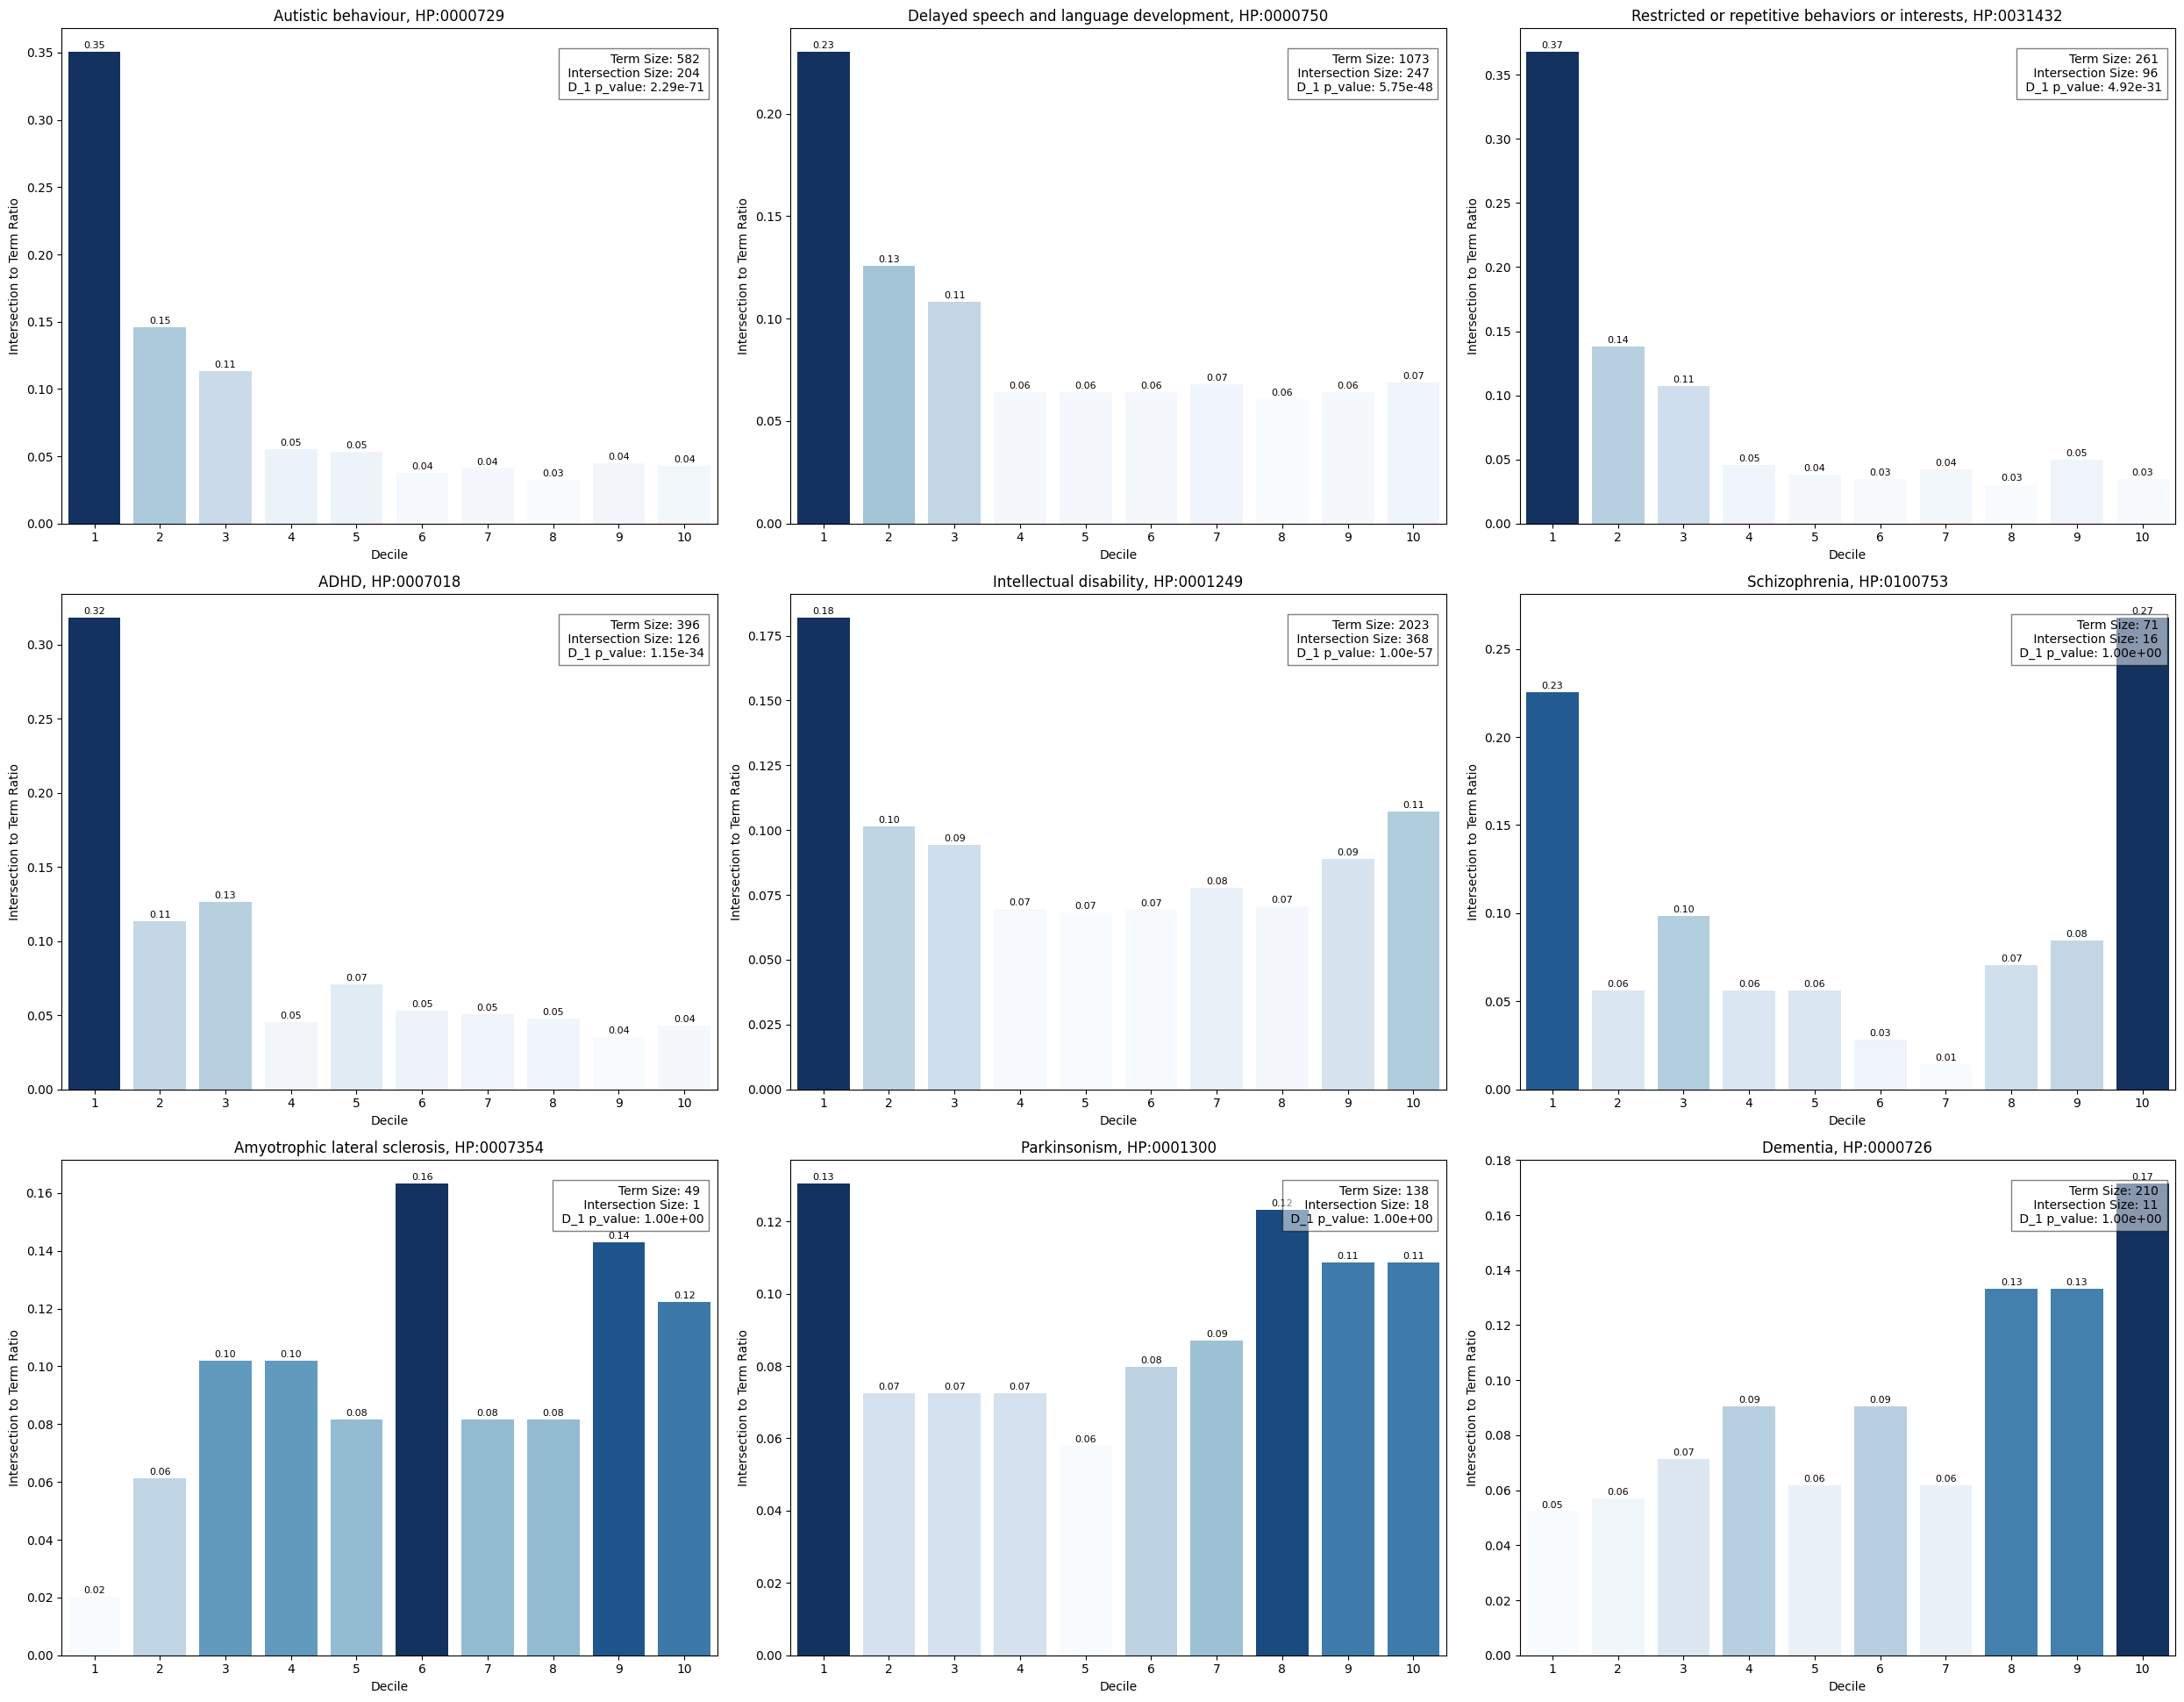

In [16]:
phenotype_list = [autistic_behaviour, delayed_speech, repetitive_behaviour, adhd, intellectual_disability, scz, als, parkinsons, dementia]

plot_comparison_graphs(phenotype_list,"Blues")

# Mutations

### Varicarta

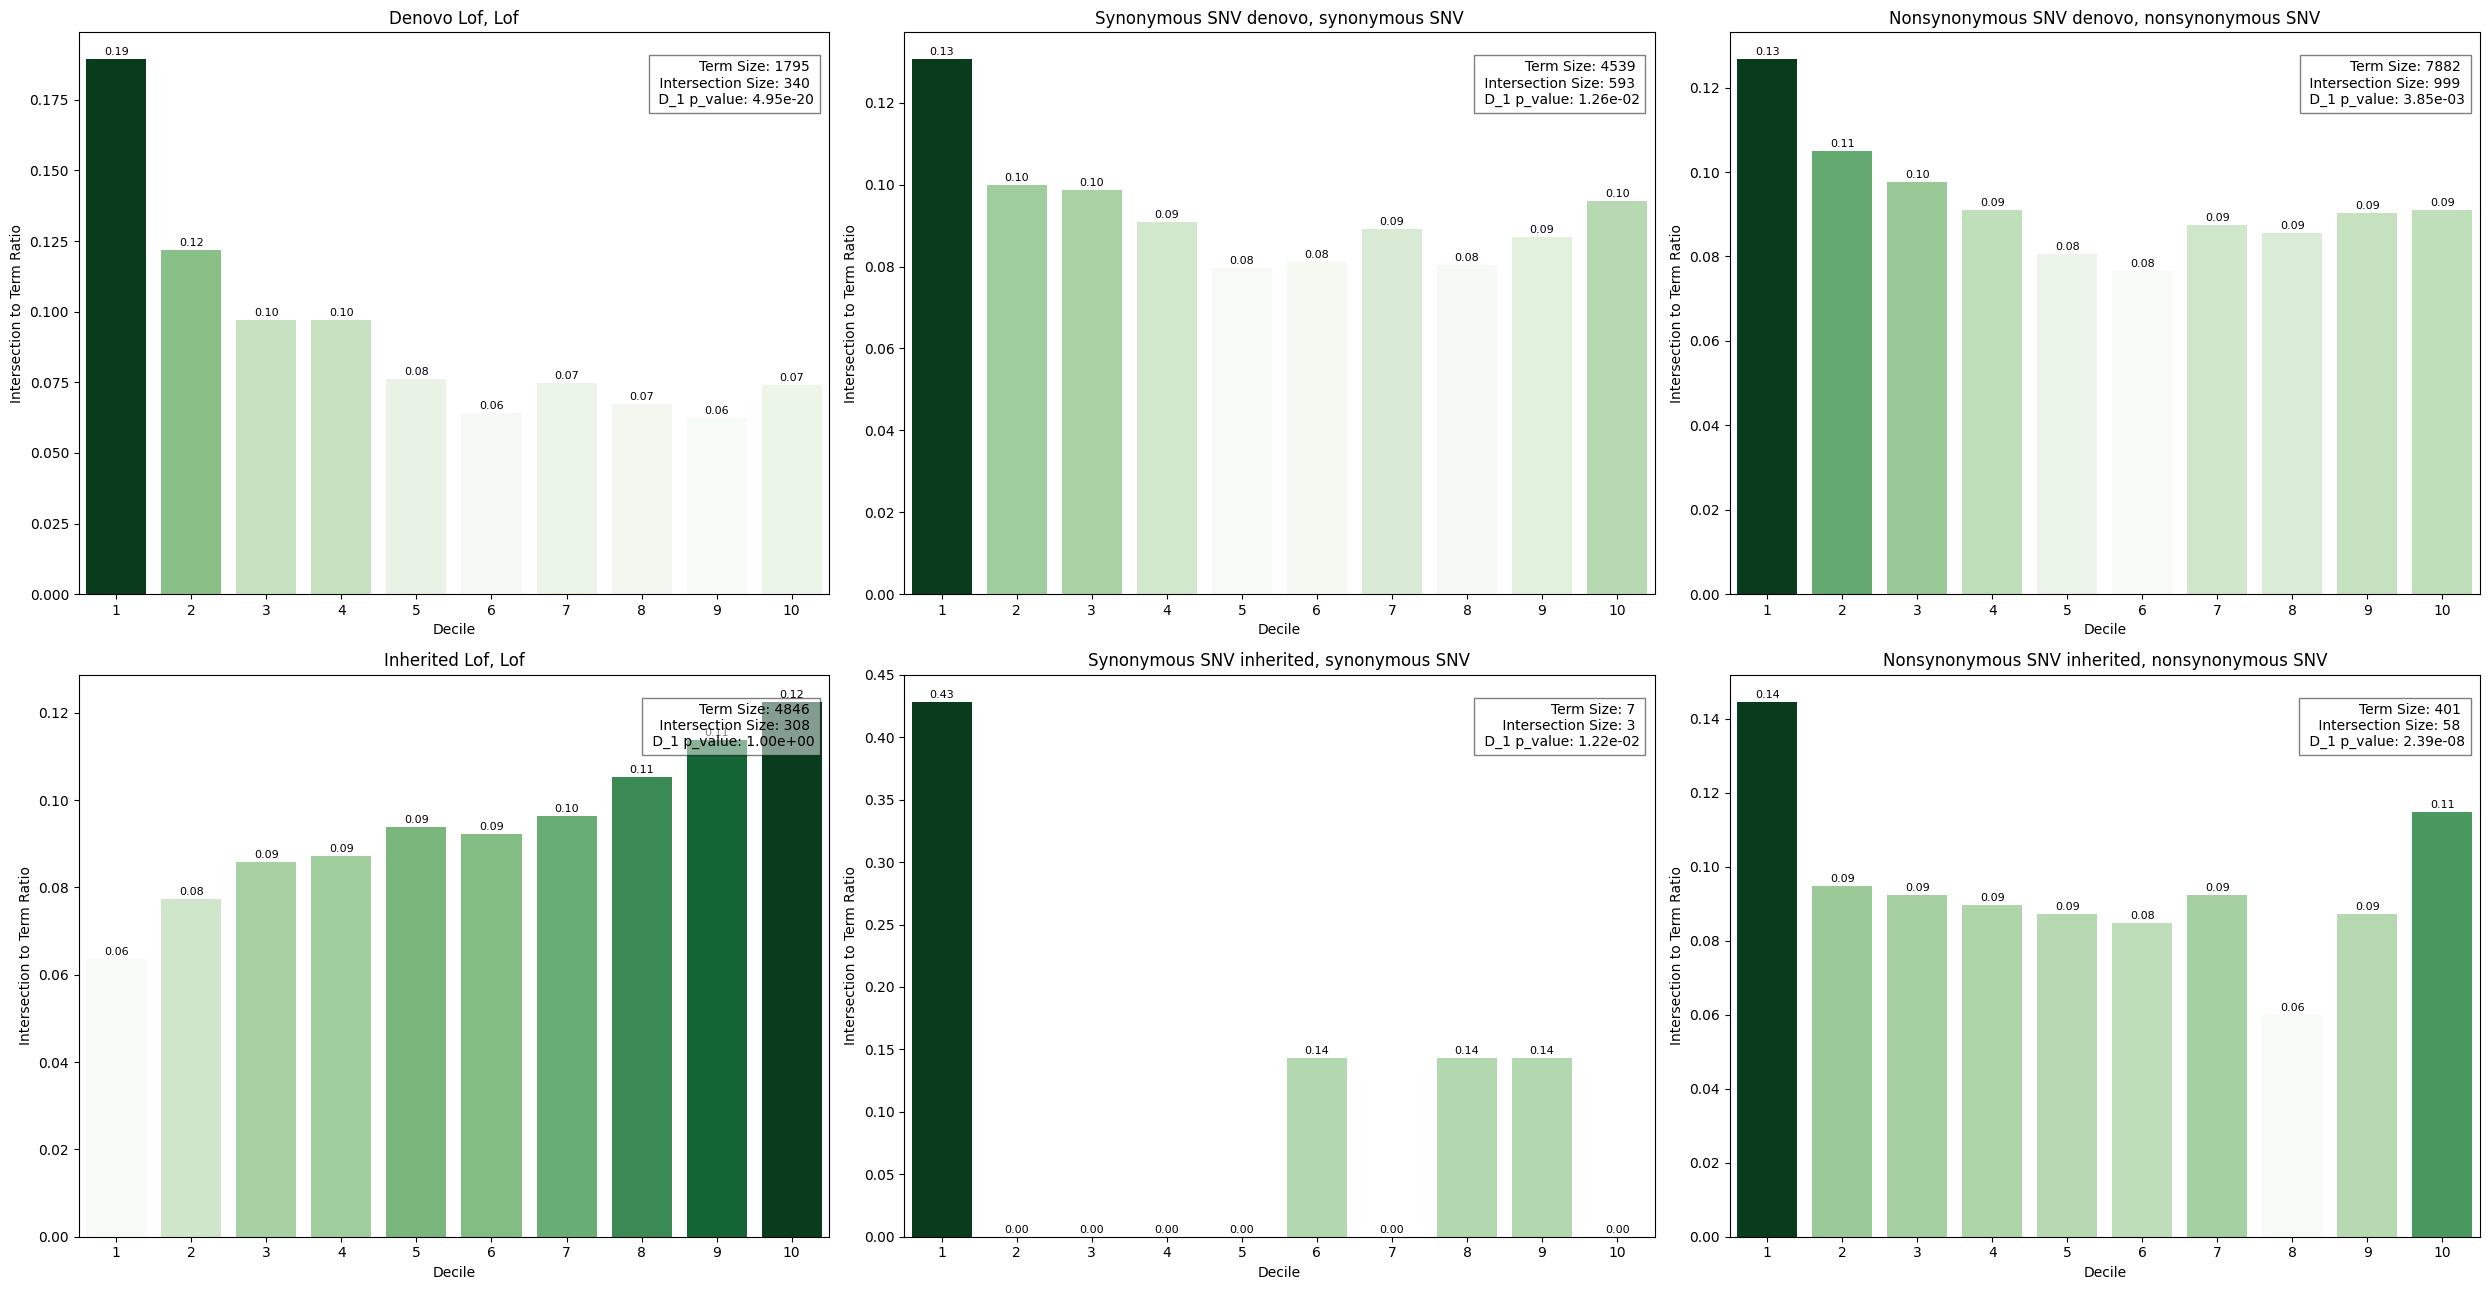

In [17]:
varicarta_list = [lof_d, synonymous_SNV_d, nonsynonymous_SNV_d, lof_in, synonymous_SNV_in, nonsynonymous_SNV_in]

plot_comparison_graphs(varicarta_list,"Greens")

# Krish and Duda

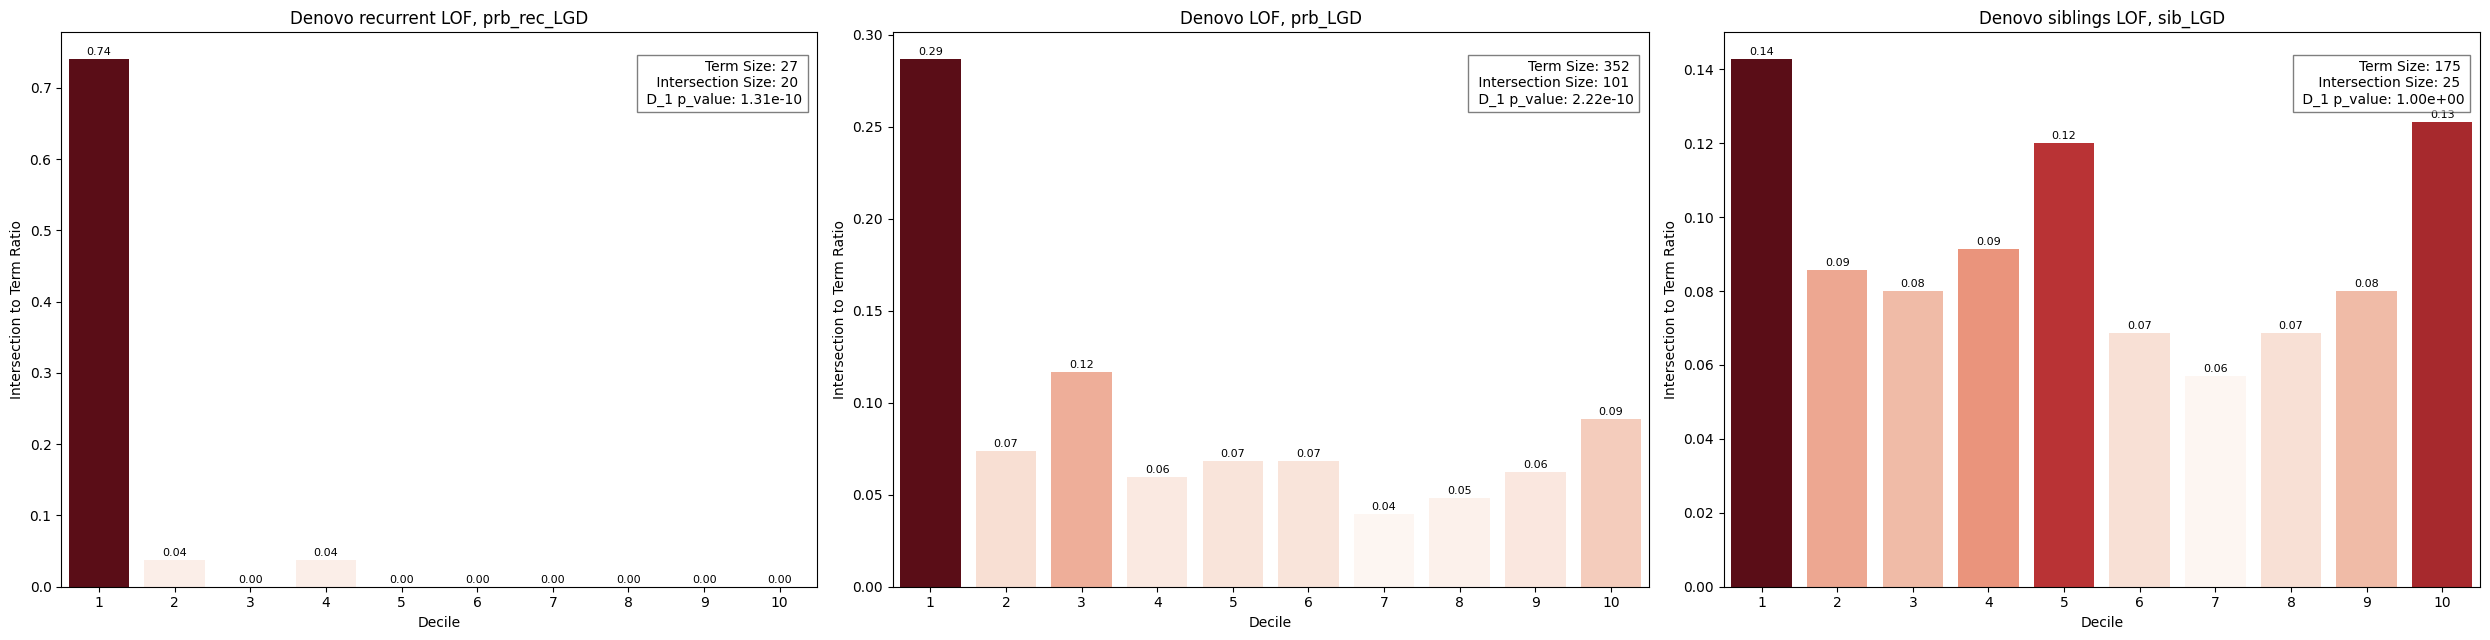

In [18]:
kris_duda_list = [proband_denovo_rec_lof, proband_denovo, siblings_denovo]

plot_comparison_graphs(kris_duda_list,"Reds")

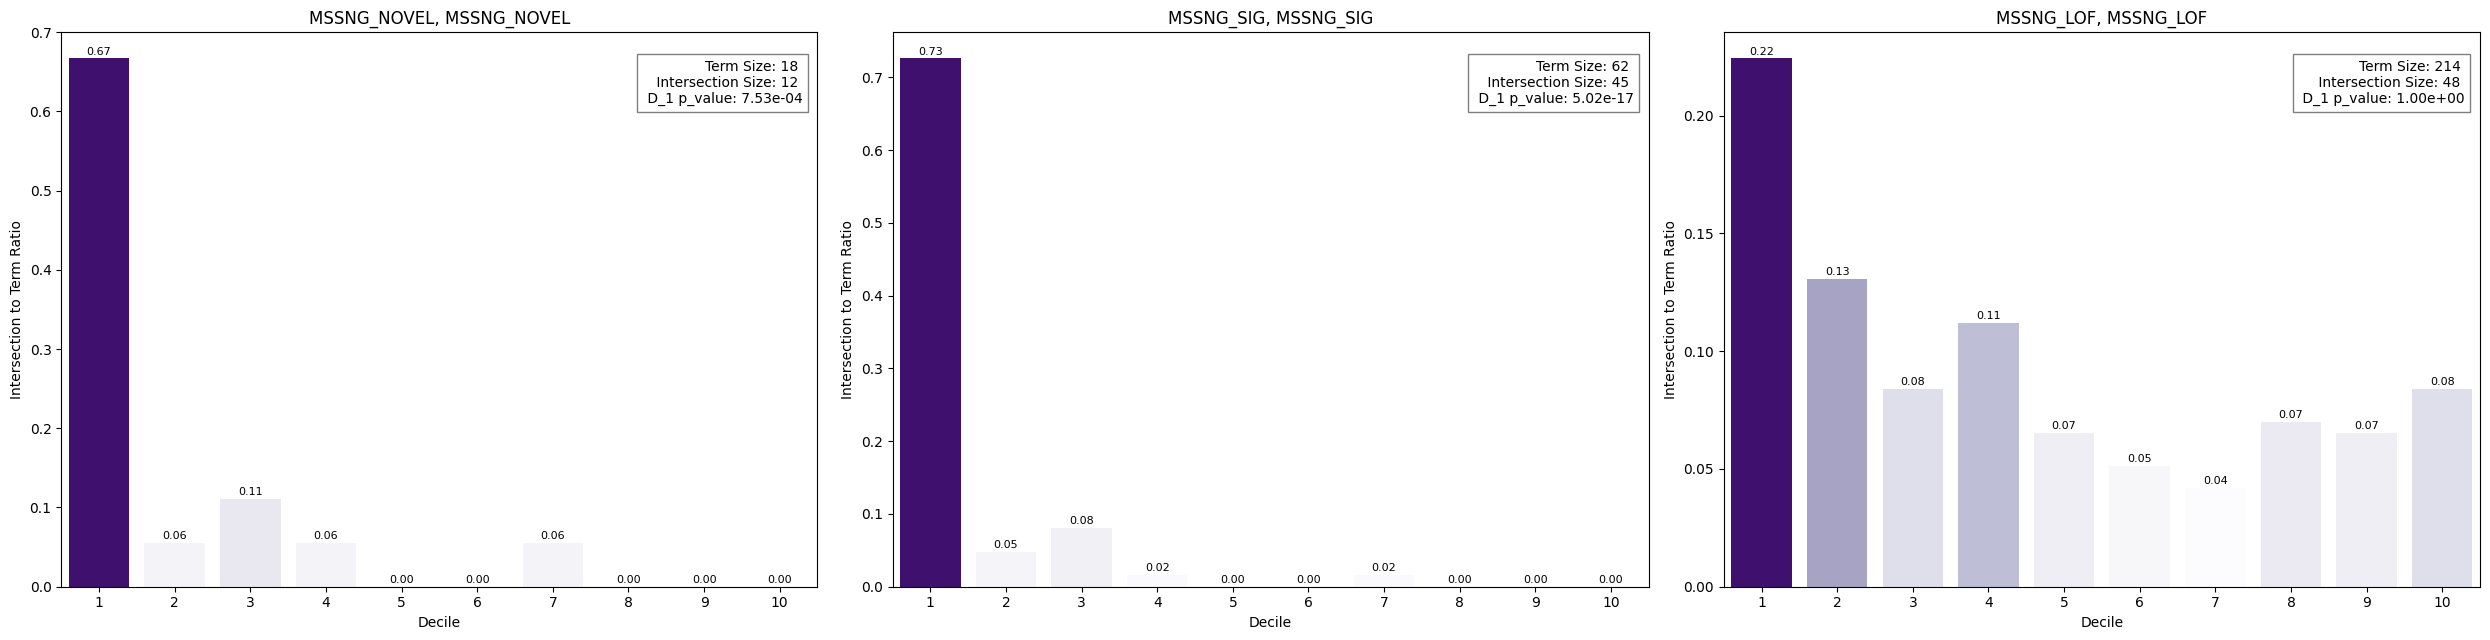

In [19]:
duda_list=[mssng_novel,mssng_sig,mssng_lof]
plot_comparison_graphs(duda_list,"Purples")

# SFARI


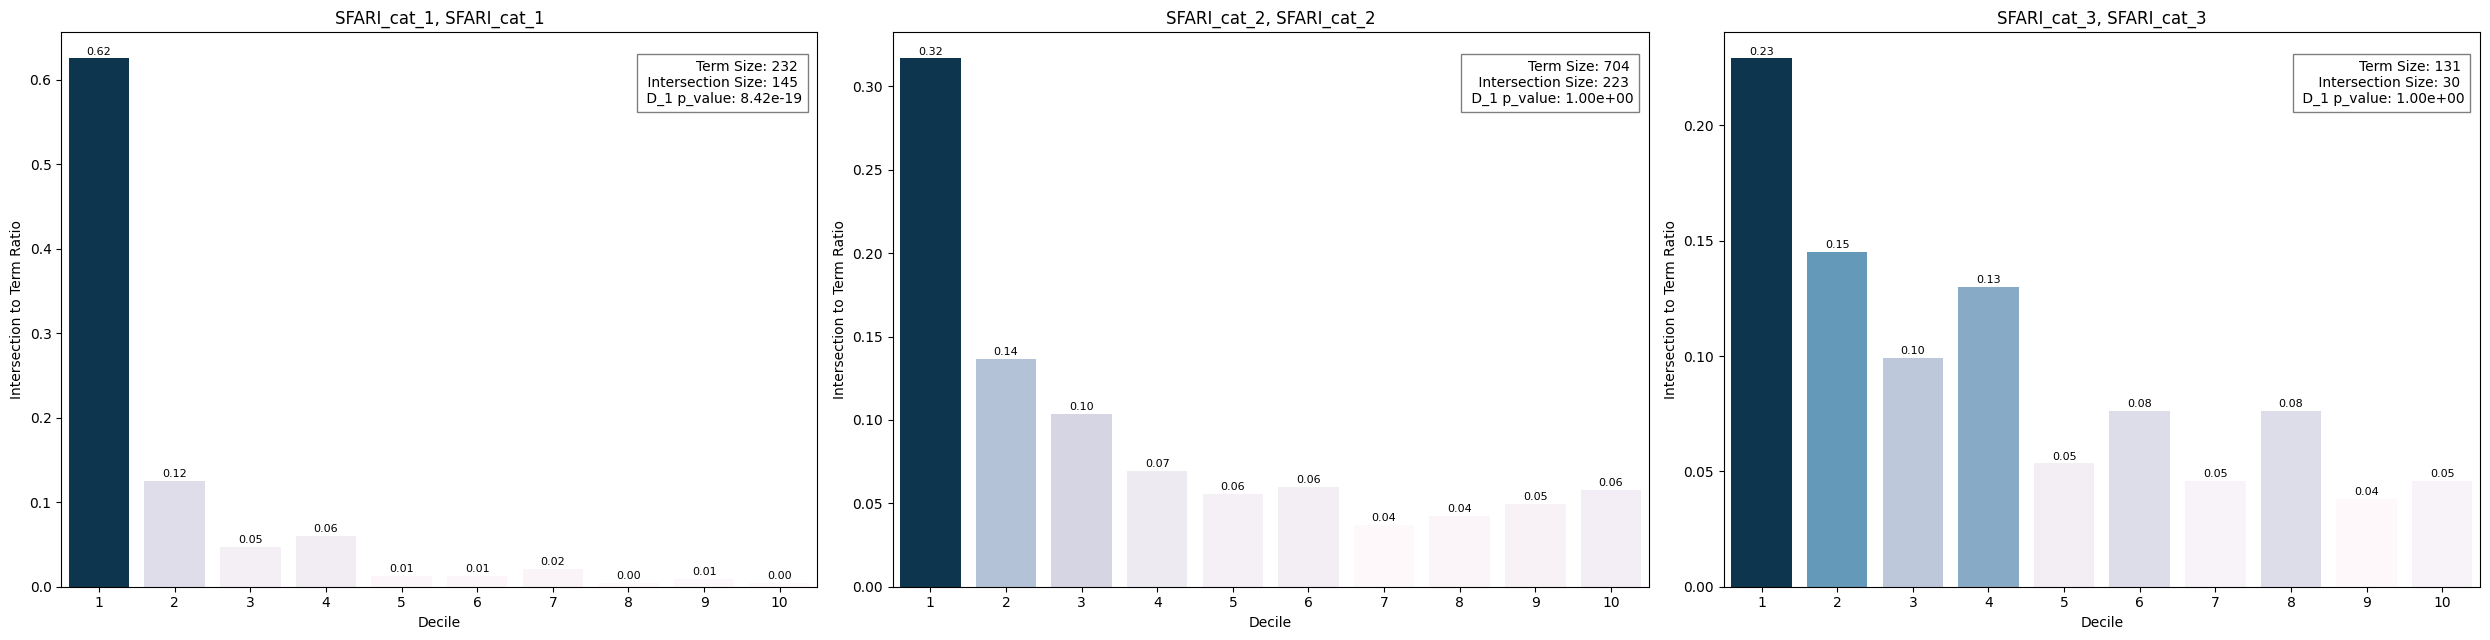

In [20]:
sfari_list=[category_1,category_2,category_3]
plot_comparison_graphs(sfari_list,"PuBu")

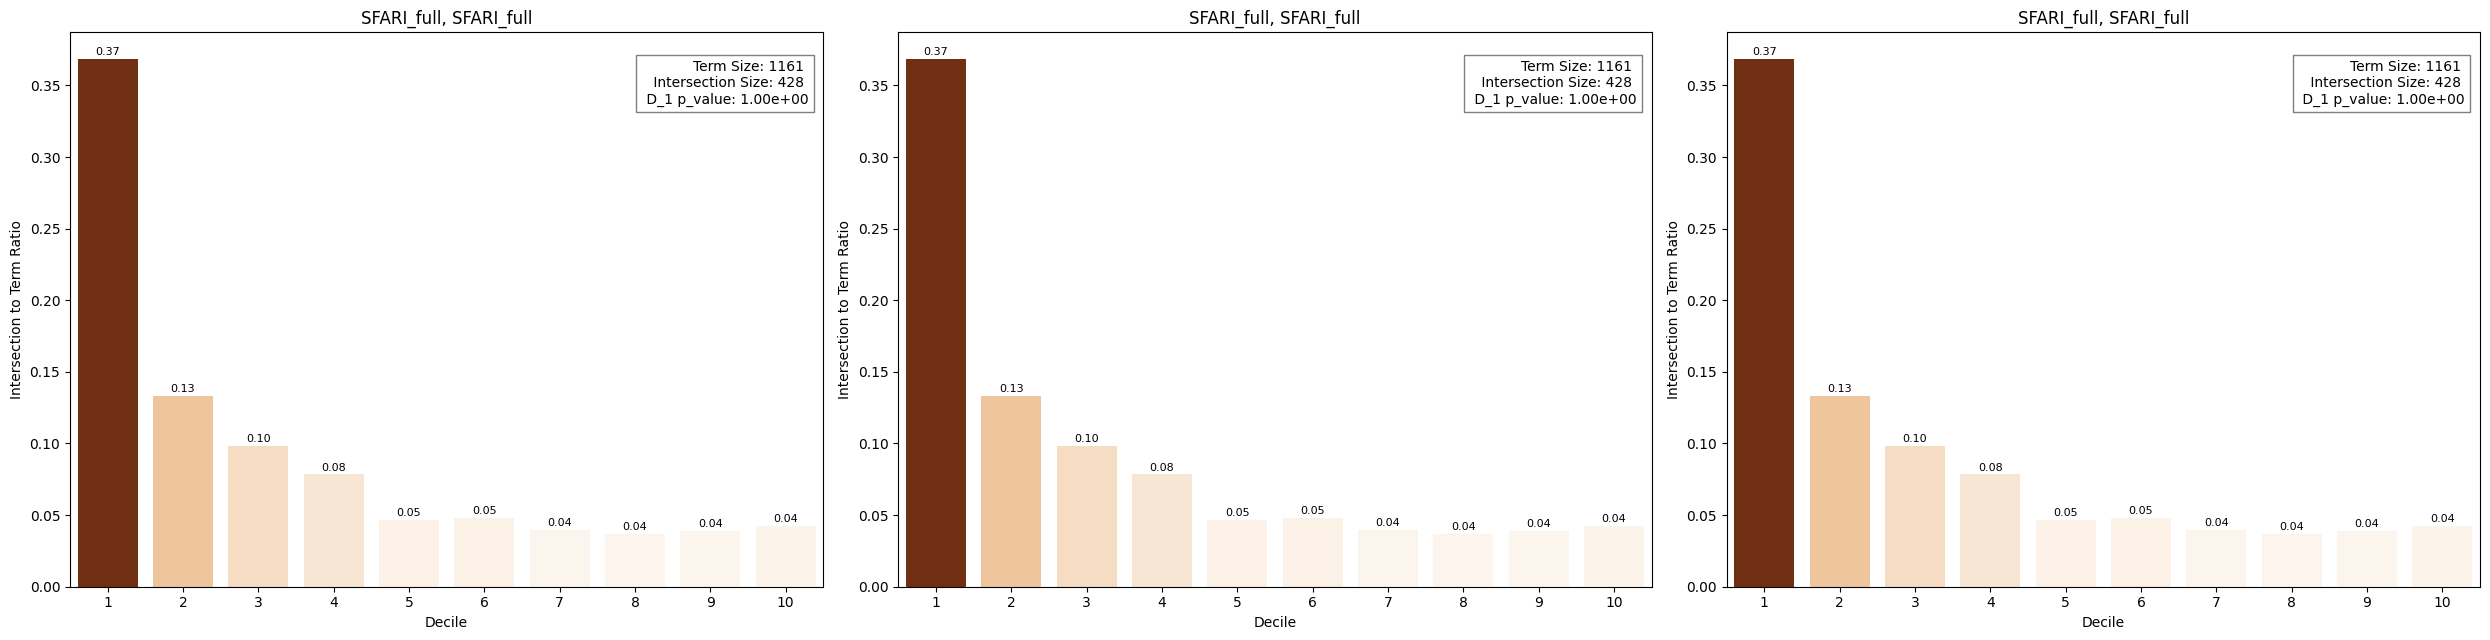

In [18]:
full_3=[sfari_full,sfari_full,sfari_full]
plot_comparison_graphs(full_3,"Oranges")